In [1]:
from utils import *

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from xgboost import XGBRegressor, DMatrix, cv
from xgboost import train as train_xgb

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])
tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

all_df = pd.concat([train_df, test_df])

coords_df = pd.read_csv('data/coords.csv', index_col='id')

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
all_df = remove_outliers(all_df)

## 4. Feature engineering

In [8]:
all_df = create_new_features(all_df)

In [9]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

## 5. Removing fake prices

In [10]:
train_df = remove_fake_prices(train_df)

REMOVED: 35


### `product_type == 'Investment'`

#### FIRST

In [11]:
train_df_0 = train_df[train_df['product_type'] == 0]

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [12]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'booster': 'gbtree',
          # 'tree_method': 'gpu_hist',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.23172	validation_1-rmse:8.24617
[1]	validation_0-rmse:7.82281	validation_1-rmse:7.83760
[2]	validation_0-rmse:7.43447	validation_1-rmse:7.44944
[3]	validation_0-rmse:7.06563	validation_1-rmse:7.08046
[4]	validation_0-rmse:6.71536	validation_1-rmse:6.73049
[5]	validation_0-rmse:6.38272	validation_1-rmse:6.39771
[6]	validation_0-rmse:6.06686	validation_1-rmse:6.08201
[7]	validation_0-rmse:5.76691	validation_1-rmse:5.78192
[8]	validation_0-rmse:5.48212	validation_1-rmse:5.49722
[9]	validation_0-rmse:5.21171	validation_1-rmse:5.22664
[10]	validation_0-rmse:4.95500	validation_1-rmse:4.96992
[11]	validation_0-rmse:4.71126	validation_1-rmse:4.72627
[12]	validation_0-rmse:4.47988	validation_1-rmse:4.49477
[13]	validation_0-rmse:4.26022	validation_1-rmse:4.27520
[14]	validation_0-rmse:4.05179	validation_1-rmse:4.06675
[15]	validation_0-rmse:3.85393	validation_1-rmse:3.86877
[16]	validation_0-rmse:3.66617	validation_1-rmse:3.68095
[17]	validation_0-rmse:3.48800	validation

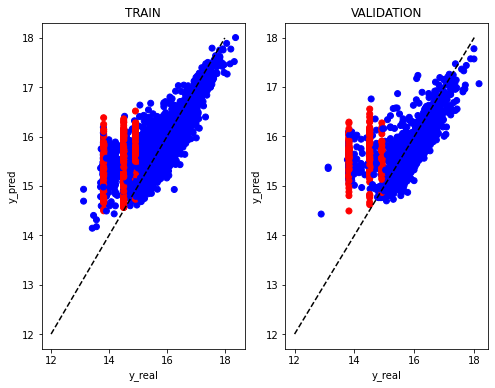

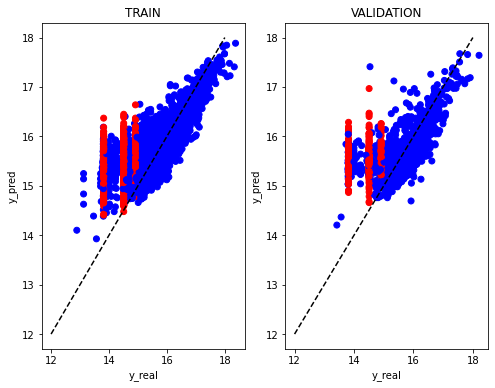

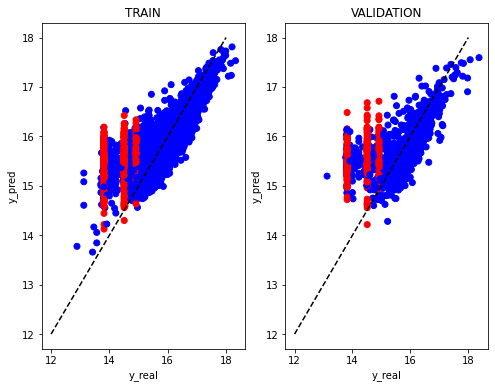

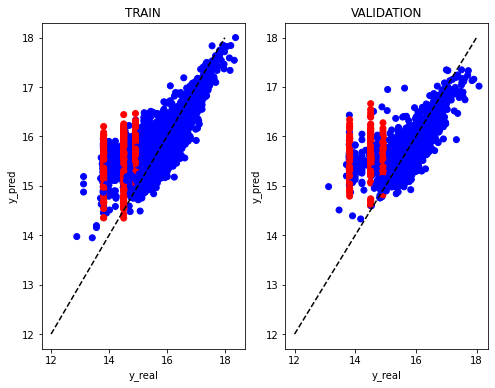

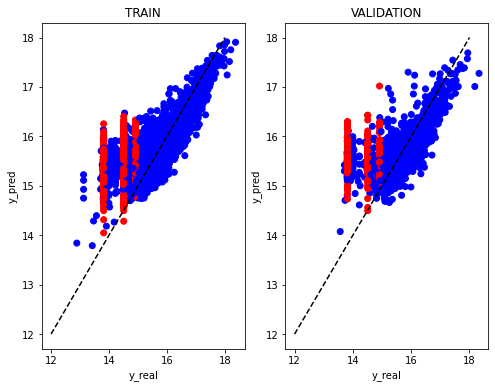

In [13]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

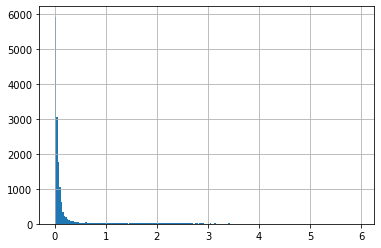

In [14]:
train_errors[4].hist(bins=200);

In [15]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 2.5].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 2.5].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)
idx_outliers.sort()

In [18]:
np.savetxt('outliers_laptop/idx_outliers_25.txt', idx_outliers, fmt='%d')
idx_outliers_25 = idx_outliers

In [19]:
# set(idx_outliers_25).difference(set(idx_outliers_old))

In [20]:
782

782

In [21]:
len(idx_outliers_25)

741

#### SECOND

In [22]:
train_df_0 = train_df[train_df['product_type'] == 0].drop(idx_outliers_25)

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [23]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'booster': 'gbtree',
          # 'tree_method': 'gpu_hist',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.29086	validation_1-rmse:8.30485
[1]	validation_0-rmse:7.87822	validation_1-rmse:7.89170
[2]	validation_0-rmse:7.48631	validation_1-rmse:7.49953
[3]	validation_0-rmse:7.11404	validation_1-rmse:7.12700
[4]	validation_0-rmse:6.76044	validation_1-rmse:6.77291
[5]	validation_0-rmse:6.42460	validation_1-rmse:6.43683
[6]	validation_0-rmse:6.10564	validation_1-rmse:6.11740
[7]	validation_0-rmse:5.80271	validation_1-rmse:5.81426
[8]	validation_0-rmse:5.51501	validation_1-rmse:5.52605
[9]	validation_0-rmse:5.24179	validation_1-rmse:5.25242
[10]	validation_0-rmse:4.98235	validation_1-rmse:4.99290
[11]	validation_0-rmse:4.73593	validation_1-rmse:4.74653
[12]	validation_0-rmse:4.50195	validation_1-rmse:4.51218
[13]	validation_0-rmse:4.27974	validation_1-rmse:4.28956
[14]	validation_0-rmse:4.06879	validation_1-rmse:4.07864
[15]	validation_0-rmse:3.86846	validation_1-rmse:3.87791
[16]	validation_0-rmse:3.67826	validation_1-rmse:3.68775
[17]	validation_0-rmse:3.49771	validation

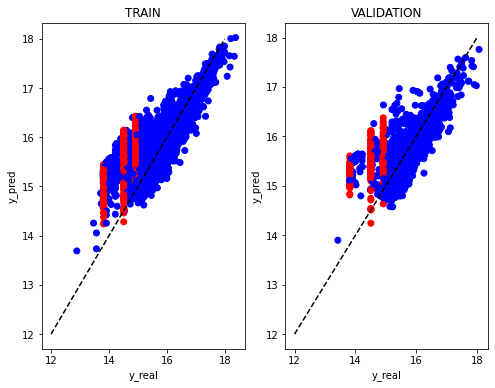

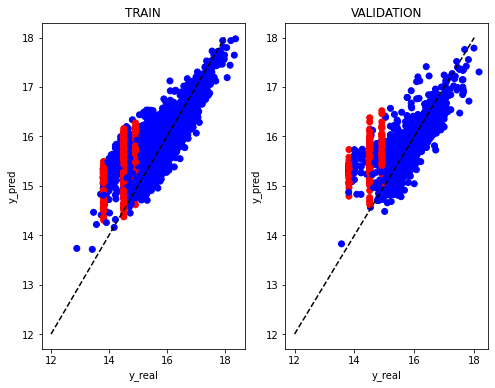

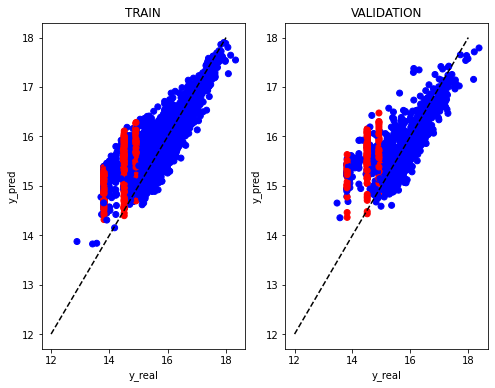

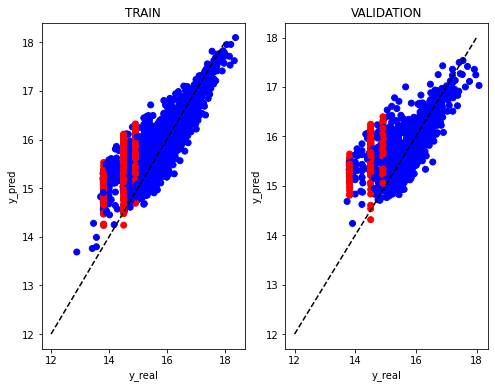

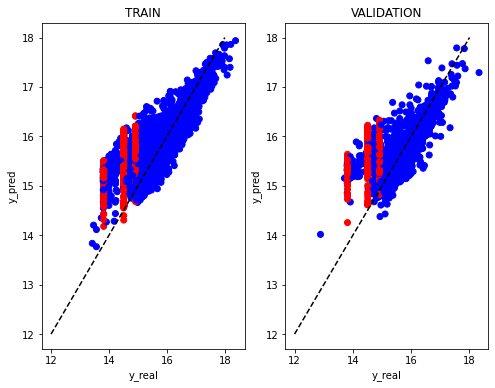

In [24]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

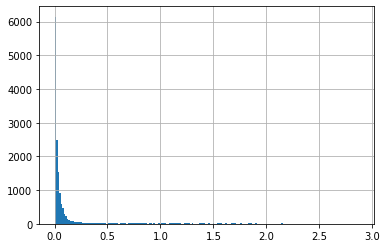

In [25]:
train_errors[4].hist(bins=200);

In [26]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 1.1].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 1.1].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)
idx_outliers.sort()

In [27]:
idx_outliers = np.append(idx_outliers, idx_outliers_25)
idx_outliers.sort()

In [28]:
# set(idx_outliers).difference(set(idx_outliers_old))

In [29]:
np.savetxt('outliers_laptop/idx_outliers_25_11.txt', idx_outliers, fmt='%d')
idx_outliers_25_11 = idx_outliers

In [30]:
1843

1843

In [31]:
len(idx_outliers_25_11)

1800

#### THIRD

In [32]:
train_df_0 = train_df[train_df['product_type'] == 0].drop(idx_outliers_25_11)

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [33]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'booster': 'gbtree',
          # 'tree_method': 'gpu_hist',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.36738	validation_1-rmse:8.36293
[1]	validation_0-rmse:7.95021	validation_1-rmse:7.94533
[2]	validation_0-rmse:7.55394	validation_1-rmse:7.54889
[3]	validation_0-rmse:7.17749	validation_1-rmse:7.17218
[4]	validation_0-rmse:6.81988	validation_1-rmse:6.81464
[5]	validation_0-rmse:6.48020	validation_1-rmse:6.47472
[6]	validation_0-rmse:6.15752	validation_1-rmse:6.15207
[7]	validation_0-rmse:5.85102	validation_1-rmse:5.84563
[8]	validation_0-rmse:5.55989	validation_1-rmse:5.55429
[9]	validation_0-rmse:5.28335	validation_1-rmse:5.27778
[10]	validation_0-rmse:5.02073	validation_1-rmse:5.01503
[11]	validation_0-rmse:4.77121	validation_1-rmse:4.76537
[12]	validation_0-rmse:4.53421	validation_1-rmse:4.52844
[13]	validation_0-rmse:4.30910	validation_1-rmse:4.30320
[14]	validation_0-rmse:4.09534	validation_1-rmse:4.08943
[15]	validation_0-rmse:3.89229	validation_1-rmse:3.88637
[16]	validation_0-rmse:3.69939	validation_1-rmse:3.69322
[17]	validation_0-rmse:3.51619	validation

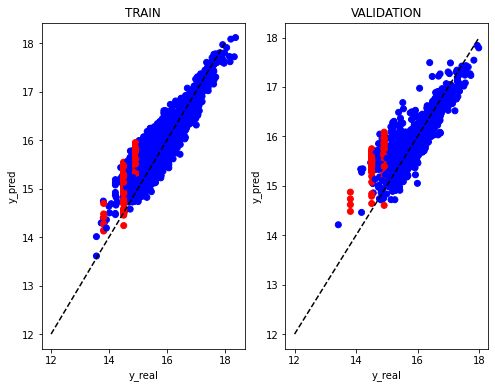

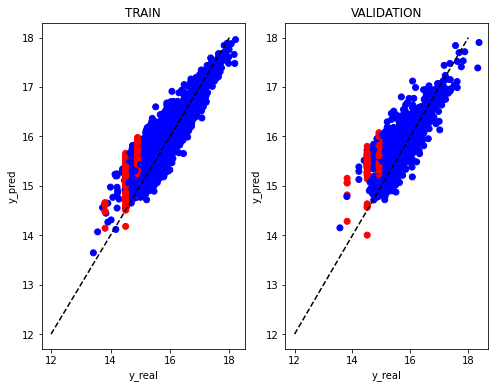

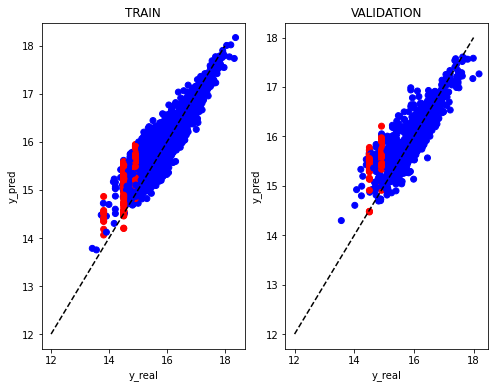

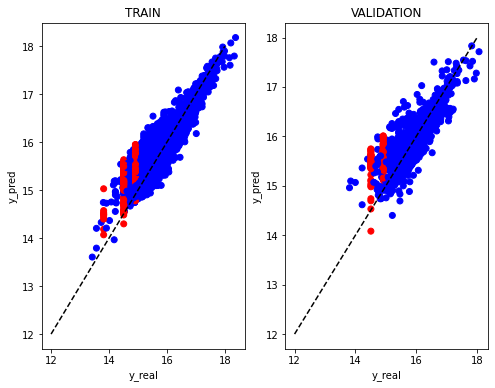

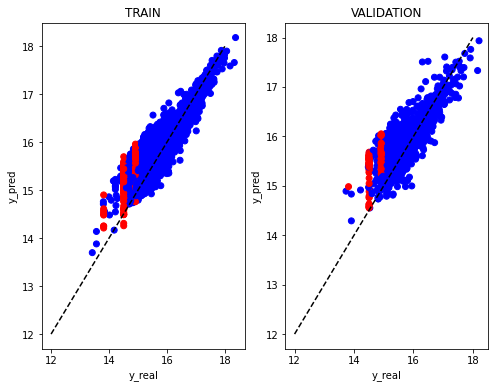

In [34]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

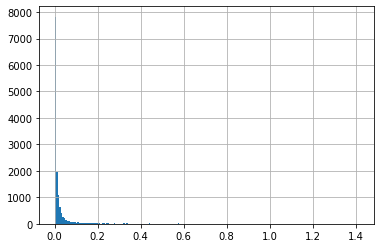

In [35]:
train_errors[4].hist(bins=200);

In [36]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 0.4].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 0.4].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)
idx_outliers.sort()

In [37]:
idx_outliers_25_11_04 = np.append(idx_outliers, idx_outliers_25_11)
idx_outliers_25_11_04.sort()

In [38]:
np.savetxt('outliers_laptop/idx_outliers_25_11_04.txt', idx_outliers_25_11_04, fmt='%d')

In [39]:
len(idx_outliers_25_11_04)

2645

In [40]:
2672

2672

In [43]:
len(np.loadtxt('outliers_laptop/idx_outliers_25_11_04.txt')), \
len(np.loadtxt('outliers_laptop/idx_outliers_25_11.txt')), \
len(np.loadtxt('outliers_laptop/idx_outliers_25.txt'))

(2645, 1800, 741)

In [ ]:
# len(idx_outliers_old)

### `product_type == 'OwnerOccupier'`

In [44]:
train_df_1 = train_df[train_df['product_type'] == 1]

X = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_1['price_doc'])

In [45]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          # 'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.14800	validation_1-rmse:8.14997
[1]	validation_0-rmse:7.74190	validation_1-rmse:7.74384
[2]	validation_0-rmse:7.35611	validation_1-rmse:7.35804
[3]	validation_0-rmse:6.98958	validation_1-rmse:6.99173
[4]	validation_0-rmse:6.64138	validation_1-rmse:6.64356
[5]	validation_0-rmse:6.31059	validation_1-rmse:6.31281
[6]	validation_0-rmse:5.99636	validation_1-rmse:5.99862
[7]	validation_0-rmse:5.69779	validation_1-rmse:5.70014
[8]	validation_0-rmse:5.41415	validation_1-rmse:5.41674
[9]	validation_0-rmse:5.14470	validation_1-rmse:5.14754
[10]	validation_0-rmse:4.88876	validation_1-rmse:4.89180
[11]	validation_0-rmse:4.64559	validation_1-rmse:4.64866
[12]	validation_0-rmse:4.41460	validation_1-rmse:4.41771
[13]	validation_0-rmse:4.19512	validation_1-rmse:4.19845
[14]	validation_0-rmse:3.98666	validation_1-rmse:3.99008
[15]	validation_0-rmse:3.78857	validation_1-rmse:3.79215
[16]	validation_0-rmse:3.60041	validation_1-rmse:3.60391
[17]	validation_0-rmse:3.42167	validation

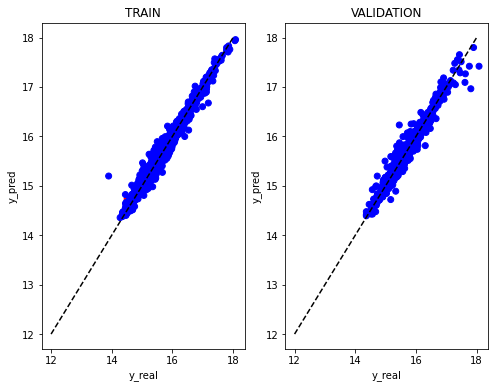

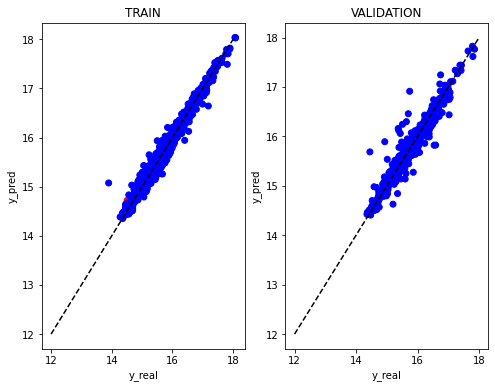

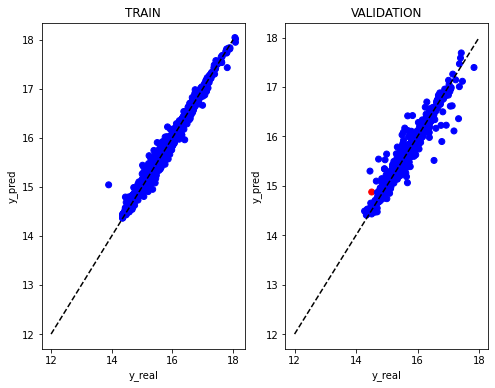

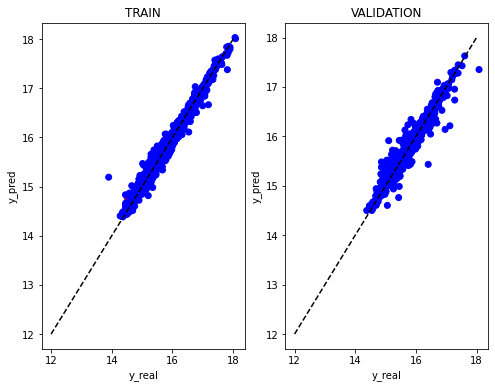

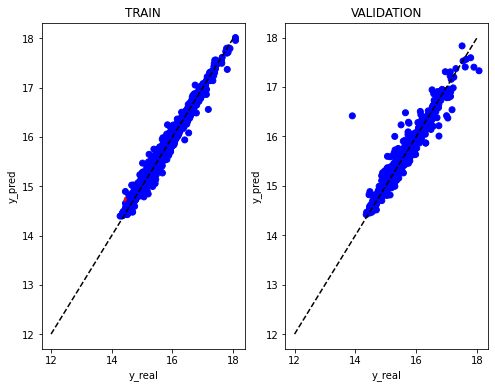

In [46]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

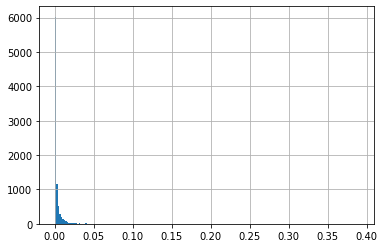

In [91]:
train_errors[4].hist(bins=200);

In [153]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 0.4].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 0.5].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)
idx_outliers.sort()

In [154]:
len(idx_outliers)

29

In [157]:
np.savetxt('outliers_laptop/idx_outliers_1.txt', idx_outliers, fmt='%d')

In [160]:
idx_outliers_full = np.loadtxt('outliers_laptop/idx_outliers_25_11_04.txt').astype(int)
idx_outliers_full = np.append(idx_outliers_full, idx_outliers)
idx_outliers_full.sort()

In [161]:
np.savetxt('outliers_laptop/idx_outliers_full.txt', idx_outliers_full, fmt='%d')

In [162]:
len(idx_outliers_25_11_04)

2645

In [163]:
len(idx_outliers_full)

2674

In [ ]:
len(np.loadtxt('data/outliers/idx_outliers_25_11_04.txt')), \
len(np.loadtxt('data/outliers/idx_outliers_25_11.txt')), \
len(np.loadtxt('data/outliers/idx_outliers_25.txt'))

(2672, 1843, 782)